In [32]:
import nevis
import matplotlib
import numpy as np
import io
import matplotlib.pyplot as plt
from PIL import Image

def make_image(
        colorbar=False, 
        starting_points=[], ending_points=[], 
        markeredgewidth=1, markersize=4, alpha=0.3,
        fig=None,
        ax=None,
        meters2indices=None,
        image_only=True,
        **kwargs):
    
    if fig is None:
        fig, ax, _, meters2indices = nevis.plot(headless=True, **kwargs)
    starting_points = np.array(starting_points)
    ending_points = np.array(ending_points)
    if np.size(starting_points) != 0:
        sx, sy = meters2indices(starting_points[:, 0], starting_points[:, 1])
        ax.plot(sx, sy, 'x', color='#0000ff', 
                markeredgewidth=markeredgewidth, markersize=markersize, alpha=alpha)
    if np.size(ending_points) != 0:
        ex, ey = meters2indices(ending_points[:, 0], ending_points[:, 1])
        ax.plot(ex, ey, 'x', color='#ff0000', 
                markeredgewidth=markeredgewidth, markersize=markersize, alpha=alpha)
    if colorbar:
        heights = nevis.gb()
        vmin = np.min(heights)
        vmax = np.max(heights)
        f = lambda x: (x - vmin) / (vmax - vmin)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'soundofmusic', [
                (0, '#4872d3'),             # Deep sea blue
                (f(-0.1), '#68b2e3'),       # Shallow sea blue
                (f(0.0), '#0f561e'),        # Dark green
                (f(10), '#1a8b33'),         # Nicer green
                (f(100), '#11aa15'),        # Glorious green
                (f(300), '#e8e374'),        # Yellow at ~1000ft
                (f(610), '#8a4121'),        # Brownish at ~2000ft
                (f(915), '#999999'),        # Grey at ~3000ft
                (1, 'white'),
            ], N=1024)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin, vmax))
        sm.set_array([])
        fig.colorbar(sm, ax=ax, fraction=0.081, pad=0.04)
    # Save the Matplotlib figure as an image in memory (in-memory file)
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)  # Reset the file pointer to the beginning of the buffer
    image = Image.open(buf)
    image = image.convert("RGB") 
    if image_only:
        return image
    
    return image, fig, ax, meters2indices

In [33]:
def combine_imgs(img1, img2, img3):
    w1, h1 = img1.size
    w2, h2 = img2.size
    w3, h3 = img3.size

    nh1 = h2 + h3
    nw1 = int(w1 * nh1 / h1)
    img1 = img1.resize((nw1, nh1))
    w1, h1 = img1.size

    # Calculate the size of the canvas
    canvas_width = w1 + w2
    canvas_height = h1

    # Create a new blank canvas
    canvas = Image.new("RGB", (canvas_width, canvas_height), (255, 255, 255))  # Use white background

    # Paste the first image onto the canvas at position (0, 0)
    canvas.paste(img1, (0, 0))

    # Paste the second image onto the canvas, adjacent to the first image
    canvas.paste(img2, (nw1, 0))  # Adjust the x-coordinate as needed
    canvas.paste(img3, (nw1, h2))

    # Save or display the combined image
    return canvas

In [34]:
x, y = nevis.ben().grid
h, bdr = nevis.macdui()
hg = h.coords.grid
def make_combined_plot(starting_points=[], ending_points=[], image_only=True, save_path=None):

    labels = {
        'Ben Nevis': [x, y],
        'Ben Macdui': hg,
    }
    image1, fig1, ax1, meters2indices1 = make_image(
        starting_points=starting_points, 
        ending_points=ending_points,
        colorbar=True, 
        labels=labels,
        image_only=False
    )
    b = 8e3
    boundaries = [x - b * 2.125, x + b * 2.125, y - b * 1.65, y + b * 1.65]
    markersize, markeredgewidth, alpha = 10, 2, 0.5
    image2, fig2, ax2, meters2indices2 = make_image(
        starting_points=starting_points, 
        ending_points=ending_points,
        markersize=markersize,
        markeredgewidth=markeredgewidth,
        alpha=alpha,
        boundaries=boundaries,
        zoom=1,
        labels=labels,
        image_only=False,
    )

    image3, fig3, ax3, meters2indices3 = make_image(
        starting_points=starting_points, 
        ending_points=ending_points,
        markersize=markersize,
        markeredgewidth=markeredgewidth,
        alpha=alpha,
        boundaries=bdr, 
        zoom=1, 
        labels=labels,
        image_only=False,
    )
    canvas = combine_imgs(image1, image2, image3)
    if save_path is not None:
        canvas.save(save_path)
    if image_only:
        return canvas
    return (canvas, 
            fig1, ax1, meters2indices1, 
            fig2, ax2, meters2indices2, 
            fig3, ax3, meters2indices3)


In [35]:
import cv2, numpy, tqdm

x, y = nevis.ben().grid
h, bdr = nevis.macdui()

def make_sequence(starting_points, ending_points, start_index=0, batch_size=None):
    empty_canvas, fig1, ax1, meters2indices1, fig2, ax2, meters2indices2, fig3, ax3, meters2indices3 = make_combined_plot(
        starting_points=starting_points[:start_index],
        ending_points=ending_points[:start_index],
        image_only=False)

    # width, height = empty_canvas.size

    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # output_video = cv2.VideoWriter(video_path, fourcc, 30.0, (width, height))

    labels = {
        'Ben Nevis': [x, y],
        'Ben Macdui': h.coords.grid,
    }
    if batch_size is not None:
        N = min(
            len(starting_points),
            start_index + batch_size,
        )
    else:
        N = len(starting_points)

    for i in tqdm.tqdm(range(start_index, N + 1)):
        image1, fig1, ax1, meters2indices1 = make_image(
            starting_points=[starting_points[i]], 
            ending_points=[ending_points[i]],
            colorbar=False, 
            fig=fig1,
            ax=ax1,
            meters2indices=meters2indices1,
            image_only=False,
            labels=labels,
        )

        b = 8e3
        boundaries = [x - b * 2.125, x + b * 2.125, y - b * 1.65, y + b * 1.65]
        markersize, markeredgewidth, alpha = 10, 2, 0.5
        image2, fig2, ax2, meters2indices2 = make_image(
            starting_points=[starting_points[i]], 
            ending_points=[ending_points[i]],
            markersize=markersize,
            markeredgewidth=markeredgewidth,
            alpha=alpha,
            fig=fig2,
            ax=ax2,
            meters2indices=meters2indices2,
            image_only=False,
            boundaries=boundaries,
            zoom=1,
            labels=labels,
        )

        image3, fig3, ax3, meters2indices3 = make_image(
            starting_points=[starting_points[i]], 
            ending_points=[ending_points[i]],
            markersize=markersize,
            markeredgewidth=markeredgewidth,
            alpha=alpha,
            fig=fig3,
            ax=ax3,
            meters2indices=meters2indices3,
            image_only=False,
            boundaries=bdr, 
            zoom=1, 
            labels=labels,
        )

        canvas = combine_imgs(img1=image1, img2=image2, img3=image3)

        canvas.save(f'../result/is/{i+1:04d}.png')
        # Convert PIL Image to NumPy array
        # numpy_image = cv2.cvtColor(numpy.asarray(canvas), cv2.COLOR_RGB2BGR)

        # Write the NumPy array to the video
        # output_video.write(numpy_image)
    
    

In [36]:
import multiprocessing
N = 1000
B = 4

x_max, y_max = nevis.dimensions()
start_points = [(x_max * np.random.random(), y_max * np.random.random()) for _ in range(N)]
end_points = [(x_max * np.random.random(), y_max * np.random.random()) for _ in range(N)]

def task(start_index, batch_size):
    return make_sequence(start_points, end_points, start_index, batch_size)

pool = multiprocessing.Pool(processes=B)
input_values = [
    (0, N // B),
    (250, N // B),
    (500, N // B),
    (750, N // B),
]

results = pool.starmap(task, input_values)
pool.close()
pool.join()

100%|█████████▉| 250/251 [08:40<00:02,  2.08s/it]


KeyboardInterrupt: 

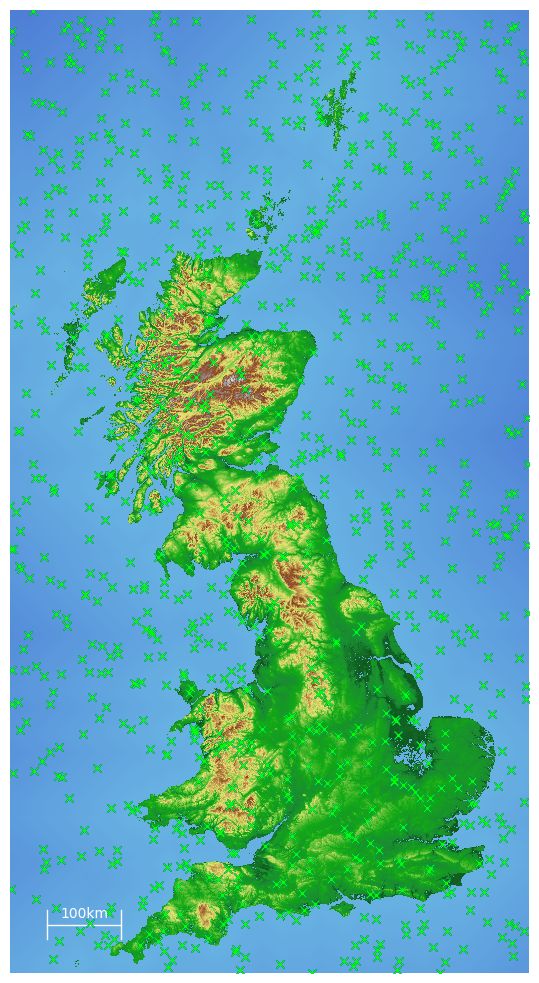

In [20]:
import nevis 
import numpy as np

fig, ax, _, g = nevis.plot()
x_max, y_max = nevis.dimensions()
N = 1000
start_points = np.array([(x_max * np.random.random(), y_max * np.random.random()) for _ in range(N)])
end_points = np.array([(x_max * np.random.random(), y_max * np.random.random()) for _ in range(N)])
sx, sy = g(start_points[:, 0], start_points[:, 1])
plot1 = ax.plot(sx, sy, 'x', color='#0000ff',)
plot2 = ax.plot(sx, sy, 'x', color='#00ff00',)
#  ax.plot(start_points[:, 0], start_points[:, 1])
fig.savefig('1.png')

In [18]:
ex, ey = g(end_points[:, 0], end_points[:, 1])
plot1[0].set_xdata(ex)
plot1[0].set_ydata(ey)
fig.canvas.draw()

In [21]:
plot2

In [19]:
fig.savefig('2.png')